<img src="https://upload.wikimedia.org/wikipedia/commons/c/c7/HEIG-VD_Logo_96x29_RVB_ROUGE.png" alt="HEIG-VD Logo" width="250"/>

# TB - DevOps: Mise en place de cloud-native storage
## Fio benchmark

Le but de ce travail de bachelor est d'explorer les différentes options de Longhorn, de juger de la qualité en tant que solution de stockage de type *cloud-native* et prendre comme point de comparaison un stockage en local et un cloud public.

Les tests sont basés sur le benchmarking réalisé par [Architecting-IT](https://resources.storageos.com/downloadbenchmarkreport). Dans le benchmarking d'Architecting-IT, StorageOs sort en tête comme que solution de stockage block. Les tests d'Architecting-IT sont disponibles [publiquement](https://github.com/architectingit/k8sstorage/blob/main/perfraw.sh).

Les choix de méthodologie et l'analyse des résultats est faite dans le rapport final. Ce notebook contient les commandes pour réaliser le benchmark et les graphiques.

## SSD/HDD local
Les résultats de cette section ont été généré avec :
```bash
$ ./fio-jobs-output/local/run-all-jobs.sh
```

In [1]:
import json
# from: https://stackoverflow.com/a/3207973
from os import listdir
from os.path import isfile, join

fio_jobs_output_path_local = 'fio-jobs-output/local/jobs'
job_outputs_filenames = [f for f in listdir(fio_jobs_output_path_local) if isfile(join(fio_jobs_output_path_local, f)) and 'output' in f]

In [2]:
job_outputs = []

# Load the results
for job_output in job_outputs_filenames:
    f = open(f"{fio_jobs_output_path_local}/{job_output}")
    data = json.load(f)
    job_outputs.append(data)

print(job_outputs[0]['fio version'])

fio-3.25


In [3]:
# Samsung Magician direct comparison
for job_output in job_outputs:
    if job_output['global options']['name'] == 'read_iops':
        print('read_iops', job_output['jobs'][0]['read']['iops'])
    if job_output['global options']['name'] == 'write_iops':
        print('write_iops', job_output['jobs'][0]['write']['iops'])
    # missing jobs for single threaded sequential read/write bandwidth benchmark

write_iops 88031.598947
read_iops 954488.617046


## Test Longhorn - Cluster IICT
### Configuration kubectl
```bash
# Use HEIG-VD VPN
# Visit https://kubernetes.iict.ch/login and log in with :
# - username: <firstname.lastname>
# - password: <ldap (your usual password for HEIG-VD)>
# Click on `iict` cluster under `Cluster Name`
# Look for `Kubeconfig File` button
# Put the content shown into `~/.kube/config`

$ kubectl config get-contexts         # is `iict` listed ?
$ kubectl config use-context iict
```

### Benchmarking avec image
Si le nombre de replicas est plus élevé que le nombre de noeuds disponibles, activez 'Replica Node Level Soft Anti-Affinity' dans le Longhorn UI pour permettre le scheduling des replicas doublons (au niveau du noeud). Ce paramètre est modifié pour le deployment `deployment-longhorn-04-five-replica.yaml`.

```bash
# <XX> is the deployment number
$ kubectl apply -f deployments/deployment-longhorn-XX-???.yaml
# monitor deployed pod activity
$ kubectl logs --follow $(kubectl get pods --namespace=mercado -o=jsonpath='{.items[0].metadata.name}') --namespace=mercado
...
All jobs done...  # wait for the benchmark to finish
ctrl-c            # stop monitoring pod activity
$ ./iict-fio-benchmark-get-output.sh <XX>
# clean-up ressources
$ kubectl delete -f deployments/deployment-longhorn-XX-???.yaml
```

In [4]:
# from: https://stackoverflow.com/a/3207973
from os import listdir
from os.path import isfile, join

fio_jobs_output_path_iict = 'docker/iict/fio-jobs'
job_outputs_filename = [f for f in listdir(fio_jobs_output_path_iict) if isfile(join(fio_jobs_output_path_iict, f))]

In [5]:
job_outputs = []

# Load the results
for job_output in job_outputs_filename:
    f = open(f"fio-jobs-output/iict/deployment-longhorn-01-fs/{job_output}-output")
    data = json.load(f)
    job_outputs.append(data)

print(job_outputs[0]['fio version'])

fio-3.27


### Benchmarking monitoré
Pour ouvrir une session ssh sur un noeud de l'école, il faut installer `remmina`. Les outils suivants sont utilisés pour monitorer le benchmarking :
* iostat
* top
* iftop

```bash
$ sudo apt install remmina remmina-plugin-vnc
$ remmina
# search bar: rpo.lan.iict.ch
# log in with:
# - username: <firstname.lastname>
# - password: <ldap (your usual password for HEIG-VD)>
# domain: einet

# Use the search bar and look for "putty", open three sessions with:
# - ip: 10.193.72.32
# Open the shell session and use your credentials:
# - username: mercado
# - password: <secret you can right-click to paste once copied>
# Once you got your three shell sessions running, you want to use:
# iostat 10
# top
# sudo iftop
# ======

# new shell to iict cluster
$ kubectl apply -f deployments/deployment-longhorn-00-manual.yaml
$ kubectl exec --namespace=mercado -it \
$(kubectl get pods -n mercado \
-o=jsonpath='{.items[0].metadata.name}') -- /bin/sh
# \ ./run-all-jobs.sh # benchmark
All jobs done...      # wait for the benchmark to finish
# \ exit              # exit interactive session
$ ./iict-fio-benchmark-get-output.sh 00
$ kubectl delete -f deployments/deployment-longhorn-00-manual.yaml
```

## Test cloud publique : cluster AWS
```bash
$ sudo apt install awscli
$ aws configure # with your AWS credentials
...
Default region name [None]: us-west-1
# install eksctl by following:
# https://docs.aws.amazon.com/eks/latest/userguide/eksctl.html
$ eksctl create cluster \
 --name fiobench-mercado \
 --region us-west-1 \
 --version 1.19 \
 --nodegroup-name fiobench-node \
 --node-type t3.small \
 --nodes 1 \
 --managed

 ...
 2021-07-16 14:35:53 [✔]  EKS cluster "fiobench-mercado" in
 "us-west-1" region is ready

# Open another shell
$ aws eks --region us-west-1 update-kubeconfig --name fiobench-mercado
Added new context arn:aws:eks:us-west-1:396229223364:cluster/fiobench-mercado to /home/brassens/.kube/config
$ kubectl auth can-i "*" "*" # can you perform anything?
yes
$ kubectl apply -f deployments/deployment-aws.yaml
$ kubectl get pod # verify pod is doing something
# when your pod is running, follow its activity:
$ kubectl logs --follow $(kubectl get pods -o=jsonpath='{.items[0].metadata.name}')
# (Optionnal) if you want to see what's inside
$ kubectl exec -it $(kubectl get pods -o=jsonpath='{.items[0].metadata.name}') -- /bin/sh
/ # top
...
CPU:   1% usr   2% sys   0% nic   3% idle  90% io   0% irq   0% sirq
# we see io number is high, indicating high activity
...
# ===
# After you see in the logs, "All jobs done..."
$ ./aws-fio-benchmark-get-output.sh
$ kubectl delete -f deployments/aws.yaml
$ eksctl delete cluster --region=us-west-1 --name=fiobench-mercado
```

**Note**: Pour une raison inconnue, le test 7 peut bloquer. Ouvrez une session interactive (`exec -it...`) et interrompez le test 7 avec `kill -9 <PID>` (déterminez le PID avec la commande `top`). Les tests suivants (8 et 9) s'exécuteront à leur tour. Exécuter les tests qui ont bloqués en ligne de commande et enfin récupérez les résultats avec le script `aws-fio-benchmark-get-output.sh`.

In [6]:
fio_jobs_output_path_aws = 'fio-jobs-output/aws'
job_outputs_filename = [f for f in listdir(fio_jobs_output_path_aws) if isfile(join(fio_jobs_output_path_aws, f))]

In [7]:
job_outputs = []

for job_output in job_outputs_filename:
    f = open(f"{fio_jobs_output_path_aws}/{job_output}")
    data = json.load(f)
    job_outputs.append(data)

print(job_outputs[0]['fio version'])

fio-3.27


## Mise à jour de l'image de benchmarking
Pour mettre à jour l'image que le cluster utilise pour benchmark (avec de nouveaux scénarios de tests ou des modifications), taggez un commit de ce repository avec, par exemple :

```bash
# <Some interesting changes to tests...>
$ git tag # what tag can we use?
...
v0.1.4
v0.1.5
v0.1.6
v0.1.7

$ git tag v0.1.8
# Trigger github action workflow `push_to_ghcr.yaml`
$ git push origin tag v0.1.8
```

Veuillez patientez, le temps que l'image soit mise en ligne par la `Github Action` puis continuez à benchmarker avec `ghcr.io/pabloheigvd/tb-fiobench:latest`.

**Note**: La `Github Action` ne build que les images en `v0.*.*` et `v1.*.*`.

# Traîtement de l'output
En s'inspirant des 9 jobs fait par Architecting-IT, on va extraire les résultats:

In [8]:
deployments_filename = [f.split('.')[0] for f in listdir('deployments/')]

def deployment_output_folder_path(host: str, idx=None):
    """
    :param host: true if the deployment is related to IICT
    :param idx: the deployment
    :return: the deployment folder path
    """
    dep = ""
    if idx is not None:
        for d in deployments_filename:
            if str(idx) in d:
                dep = '/' + d

    if host == 'local':
        dep = '/jobs'

    return f"fio-jobs-output/{host}{dep}"

print(deployment_output_folder_path(host='iict', idx=1))
print(deployment_output_folder_path(host='local'))
print(deployment_output_folder_path(host='aws'))

fio-jobs-output/iict/deployment-longhorn-01-fs
fio-jobs-output/local/jobs
fio-jobs-output/aws


In [9]:
def deployment_output(deployment_output_folder: str):
    """
    :param deployment_output_folder:
    :return: a filtered view of all jobs with relevant metrics
    """
    output = {}
    output['deployment name'] = deployment_output_folder
    for f in listdir(deployment_output_folder):
        if '-output' not in f:
            continue
        o = json.load(open(f"{deployment_output_folder}/{f}"))
        if o['global options']['name'] == 'read_iops':
            # iops_mean is a stop criteria?
            output['read_iops'] = o['jobs'][0]['read']['iops']
        if o['global options']['name'] == 'write_iops':
            output['write_iops'] = o['jobs'][0]['write']['iops']
        if o['global options']['name'] == 'read_bw':
            output['read_bw_mean'] = o['jobs'][0]['read']['bw_mean']
        if o['global options']['name'] == 'write_bw':
            output['write_bw_mean'] = o['jobs'][0]['write']['bw_mean']
        if o['global options']['name'] == 'read_latency':
            # slat: submission to kernel latency
            # clat: submission+completion latency
            # lat: TODO verify ~s+clat
            output['read_latency'] = float(o['jobs'][0]['read']['lat_ns']['mean'])/1000 # nano to micro (nsec to usec)
        if o['global options']['name'] == 'write_latency':
             output['write_latency'] = float(o['jobs'][0]['write']['lat_ns']['mean'])/1000 # nano to micro (nsec to usec)
        if o['global options']['name'] == 'seq_read':
            output['seq_read_bw'] = float(o['jobs'][0]['read']['bw_mean'])/1000 # KiB/s -> MiB/s
        if o['global options']['name'] == 'seq_write':
            output['seq_write_bw'] = float(o['jobs'][0]['write']['bw_mean'])/1000 # KiB/s -> MiB/s
        if o['global options']['name'] == 'rw_mix':
            output['rw_mix_read'] = o['jobs'][0]['read']['iops']
            output['rw_mix_write'] = o['jobs'][0]['write']['iops']
    return output

deployment_local = deployment_output(deployment_output_folder_path(host='local'))
deployment_01_iict = deployment_output(deployment_output_folder_path(host='iict', idx=1))
deployment_aws = deployment_output(deployment_output_folder_path(host='aws'))

print(deployment_local['deployment name'])
print(deployment_01_iict['deployment name'])
print(deployment_aws['deployment name'])

fio-jobs-output/local/jobs
fio-jobs-output/iict/deployment-longhorn-01-fs
fio-jobs-output/aws


## Graphiques
On veut réaliser une comparaison avec des graphiques sur les différentes métriques testées.

### Exclusion de local benchmark
Le benchmark réalisé en local va être exclu des graphiques.

In [10]:
deployment_output_folder = deployment_output_folder_path(host='local')

for f in listdir(deployment_output_folder):
        if '-output' not in f:
            continue
        o = json.load(open(f"{deployment_output_folder}/{f}"))
        if o['global options']['name'] == 'read_iops':
            print('read_iops\t', '{0:.2f}'.format(o['jobs'][0]['read']['iops']))
        if o['global options']['name'] == 'write_iops':
            print('write_iops\t', '{0:.2f}'.format(o['jobs'][0]['write']['iops']))
        # no Mo/s metrics
        # if o['global options']['name'] == 'seq_read':
        #     print()
        # if o['global options']['name'] == 'seq_write':
        #     print()

write_iops	 88031.60
read_iops	 954488.62


In [11]:
def print_difference(dep1, dep2):
    """
    :param dep1: deployment 1
    :param dep2: deployment 2
    """
    metrics_difference = {}

    for m in dep1:
        if m == 'deployment name':
            continue
        elif 'latency' in m:
            # lower is better
            metrics_difference[m] = (float(dep2[m])-float(dep1[m]))/float(dep2[m])*100
        else:
            # higher is better
            metrics_difference[m] = (float(dep1[m])-float(dep2[m]))/float(dep2[m])*100

    print(f"How better is {dep1['deployment name']} from {dep2['deployment name']}?")
    for m in sorted(metrics_difference):
        print(m, '\t', '{0:.2f}'.format(metrics_difference[m]))
    print()

print_difference(
    dep1=deployment_output(deployment_output_folder_path(host='local')),
    dep2=deployment_output(deployment_output_folder_path(host='iict', idx=3)),
)

print_difference(
    dep1=deployment_output(deployment_output_folder_path(host='local')),
    dep2=deployment_output(deployment_output_folder_path(host='aws')),
)

How better is fio-jobs-output/local/jobs from fio-jobs-output/iict/deployment-longhorn-03-three-replica?
read_bw_mean 	 126949.98
read_iops 	 67689.29
read_latency 	 100.00
rw_mix_read 	 27904.32
rw_mix_write 	 27717.23
seq_read_bw 	 471.48
seq_write_bw 	 62.80
write_bw_mean 	 12308.88
write_iops 	 2145.02
write_latency 	 99.25

How better is fio-jobs-output/local/jobs from fio-jobs-output/aws?
read_bw_mean 	 5272.69
read_iops 	 31721.94
read_latency 	 99.18
rw_mix_read 	 2941.57
rw_mix_write 	 2948.29
seq_read_bw 	 8391.41
seq_write_bw 	 129.28
write_bw_mean 	 2753.11
write_iops 	 2835.36
write_latency 	 96.29



### Comparaison cluster IICT/AWS

In [12]:
deployments = [
    # deployment_output(deployment_output_folder_path(host='local')),
    # deployment_output(deployment_output_folder_path(host='iict', idx=1)),
    deployment_output(deployment_output_folder_path(host='iict', idx=2)),
    deployment_output(deployment_output_folder_path(host='iict', idx=3)),
    deployment_output(deployment_output_folder_path(host='iict', idx=4)),
    deployment_output(deployment_output_folder_path(host='iict', idx=5)),
    deployment_output(deployment_output_folder_path(host='iict', idx=6)),
    deployment_output(deployment_output_folder_path(host='aws')),
]

deployment_names = [d['deployment name'] for d in deployments]
deployment_names = [d.replace('fio-jobs-output/local/jobs', 'local')
                    .replace('fio-jobs-output/aws', 'aws')
                    .replace('fio-jobs-output/iict/deployment-longhorn-', '')
                    .replace('01-', '')
                    .replace('02-', '')
                    .replace('03-', '')
                    .replace('04-', '')
                    .replace('05-', '')
                    .replace('06-', '')
                    .replace('network-effect', '')
                    .replace('-', ' ')
                    for d in deployment_names]

for d_name in deployment_names:
    print(d_name)

one replica
three replica
five replica
 local replica
 remote replica
aws


In [13]:
# default figure file type and dpi
figure_format = 'svg'
figure_dpi = 1200
longhorn_color = '#7BC8F6'
longhorn_color2 = '#ADD8E6'
aws_color = '#FFA500'
aws_color2 = '#FAC205'

# https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html
import matplotlib.patches as mpatches

handles = [
    mpatches.Patch(color=longhorn_color, label='Longhorn'),
    mpatches.Patch(color=aws_color, label='AWS'),
]

In [14]:
from matplotlib import pyplot as plt
plt.ioff()
from IPython.display import SVG, display

metrics = [
    ('read_iops', 'Read IOPS', 'IOPS'),
]

def build_graph_metric(key, title, unit, higher=True, display_percentages=True):
    metric = [d[key] for d in deployments]

    # express Longhorn deployments metric as a percentage of AWS deployment metric
    percentages = ["{0:.2f}".format(100 * m/metric[len(metric) - 1]) + "%" for m in metric[:len(metric) - 1]] + ["100%"]


    fig = plt.figure(figsize=(12,5))
    # display legends: https://stackoverflow.com/a/19576608
    ax = fig.add_axes([0.1,0.1,0.75,0.75])
    ax.set_title(f"{title}\n({'higher' if higher else 'lower'} is better)")
    ax.set_xlabel('deployments')
    ax.set_ylabel(unit)
    bars = plt.bar(deployment_names, metric)
    for i in range(len(metric)):
        # rounding to 3 significant digits: https://stackoverflow.com/a/3411731
        m = '%s' % ('{0:,}'.format(float('{0:.3g}'.format(metric[i]))))
        # removed '.0' by not showing last 2 caracters
        plt.annotate(m[:len(m) - 2], xy=(deployment_names[i],metric[i]), ha='center', va='bottom')

    if display_percentages:
        for idx,rect in enumerate(bars):
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 0.5*height,
                    s=percentages[idx],
                    ha='center', va='bottom')

    plt.legend(handles=handles)
    for b in bars[0:len(bars)-1]:
        b.set_color(longhorn_color)
    bars[len(bars)-1].set_color(aws_color)
    img_name = f'figures/{key}.' + figure_format
    plt.savefig(img_name, format=figure_format, dpi=figure_dpi)
    display(SVG(img_name))
    plt.close() # cannot save until plt is out of scope

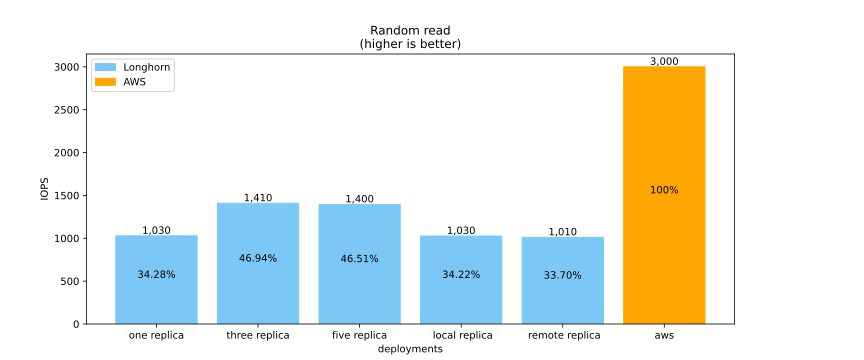

In [15]:
build_graph_metric('read_iops', 'Random read', 'IOPS')

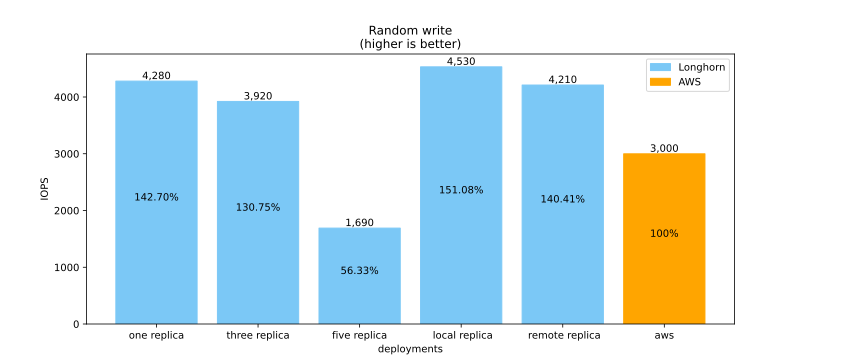

In [16]:
build_graph_metric('write_iops', 'Random write', 'IOPS')

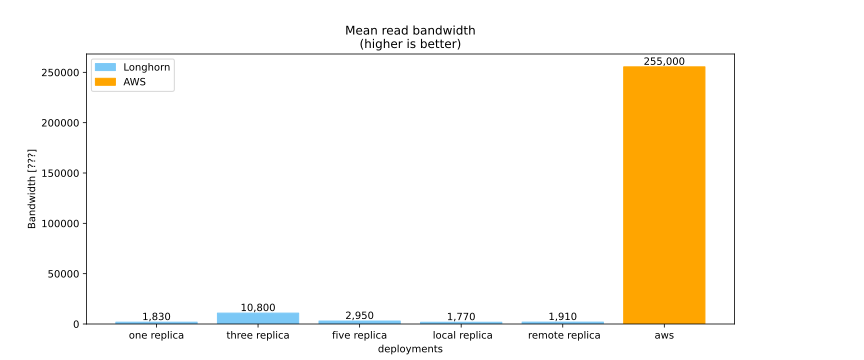

In [17]:
build_graph_metric('read_bw_mean', 'Mean read bandwidth', 'Bandwidth [???]', display_percentages=False)

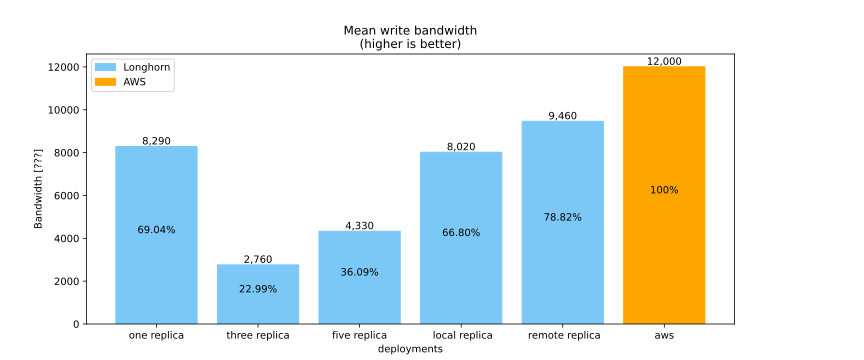

In [18]:
build_graph_metric('write_bw_mean', 'Mean write bandwidth', 'Bandwidth [???]')

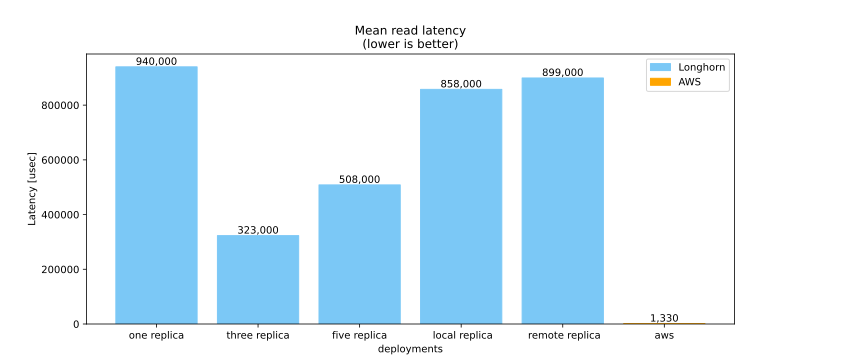

In [19]:
build_graph_metric('read_latency', 'Mean read latency', 'Latency [usec]', higher=False, display_percentages=False)

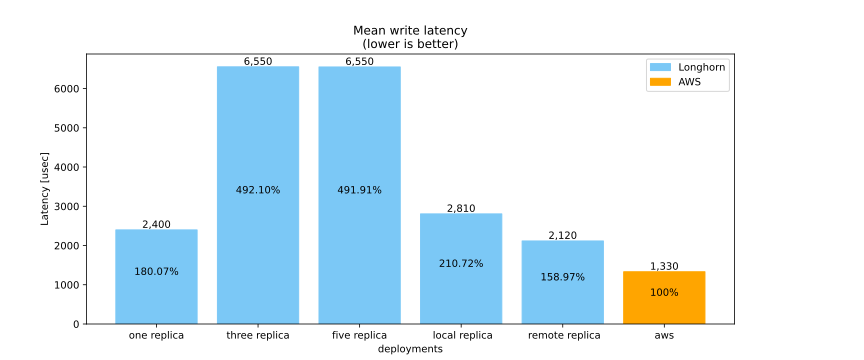

In [20]:
build_graph_metric('write_latency', 'Mean write latency', 'Latency [usec]', higher=False)

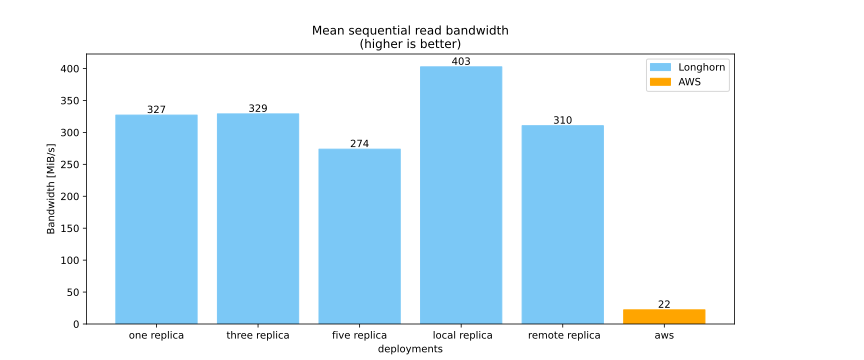

In [21]:
build_graph_metric('seq_read_bw', 'Mean sequential read bandwidth', 'Bandwidth [MiB/s]', display_percentages=False)

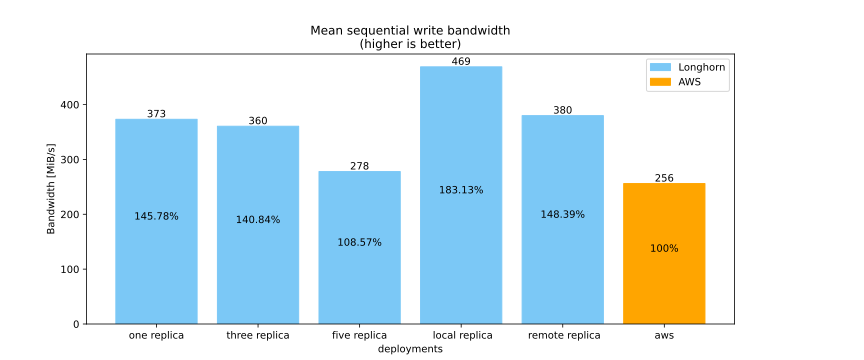

In [22]:
build_graph_metric('seq_write_bw', 'Mean sequential write bandwidth', 'Bandwidth [MiB/s]')

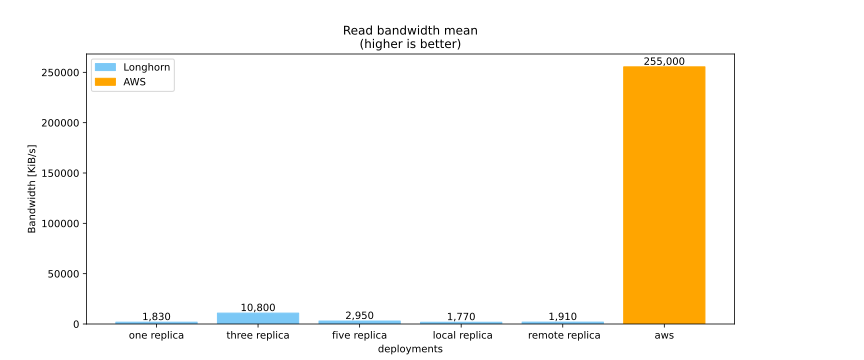

In [23]:
build_graph_metric('read_bw_mean', 'Read bandwidth mean', 'Bandwidth [KiB/s]', display_percentages=False)

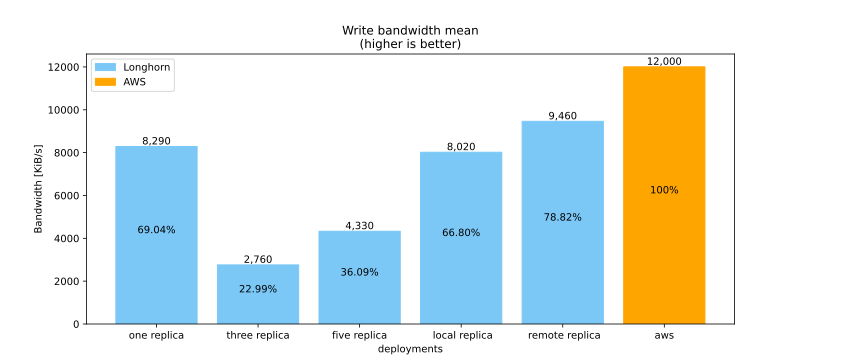

In [24]:
build_graph_metric('write_bw_mean', 'Write bandwidth mean', 'Bandwidth [KiB/s]')

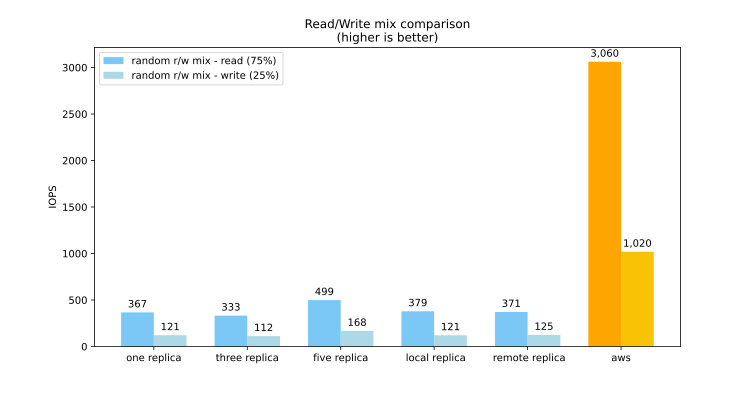

In [25]:
import numpy as np

# https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
x = np.arange(len(deployments))
width = 0.35

rw_mix_read = [d['rw_mix_read'] for d in deployments]
rw_mix_write = [d['rw_mix_write'] for d in deployments]

# express Longhorn deployments metric as a percentage of AWS deployment metric
percentages_read = ["{0:.2f}".format(100 * m/rw_mix_read[len(rw_mix_read) - 1]) + "%" for m in rw_mix_read[:len(rw_mix_read) - 1]] + ["100%"]
percentages_write = ["{0:.2f}".format(100 * m/rw_mix_write[len(rw_mix_write) - 1]) + "%" for m in rw_mix_write[:len(rw_mix_write) - 1]] + ["100%"]

color1 = [longhorn_color] * (len(rw_mix_write) - 1)
color2 = [longhorn_color2] * (len(rw_mix_write) - 1)

fig, ax = plt.subplots()
fig.set_size_inches(10.5, 5.5) # manually adjust for names to fit
rects1 = ax.bar(x - width/2, rw_mix_read, width=width, label = 'random r/w mix - read (75%)', color=color1 + [aws_color])
rects2 = ax.bar(x + width/2, rw_mix_write, width=width, label = 'random r/w mix - write (25%)', color=color2 + [aws_color2])

ax.set_ylabel('IOPS') # TODO unit
ax.set_title('Read/Write mix comparison\n(higher is better)')
ax.set_xticks(x)
ax.set_xticklabels(deployment_names)
ax.legend()

# for idx,rect in enumerate(rects1):
#             height = rect.get_height()
#             ax.text(rect.get_x() + rect.get_width()/2., 0.5*height,
#                     s=percentages_read[idx],
#                     ha='center', va='bottom')
#
# for idx,rect in enumerate(rects2):
#             height = rect.get_height()
#             ax.text(rect.get_x() + rect.get_width()/2., 0.5*height,
#                     s=percentages_write[idx],
#                     ha='center', va='bottom')

read_truncated = ['%s' % ('{0:,}'.format(float('{0:.3g}'.format(r)))) for r in rw_mix_read]
read_truncated = [m[:len(m) - 2] for m in read_truncated]

write_truncated = ['%s' % ('{0:,}'.format(float('{0:.3g}'.format(w)))) for w in rw_mix_write]
write_truncated = [m[:len(m) - 2] for m in write_truncated]

ax.bar_label(rects1, padding=3, labels=read_truncated)
ax.bar_label(rects2, padding=3, labels=write_truncated)

# fig.tight_layout()

img_name = 'figures/rw_mix.' + figure_format
plt.savefig(img_name, format=figure_format, dpi=figure_dpi)
display(SVG(img_name))
plt.close()
